# Import all needed libraries

In [1]:
!pip install matplotlib
!pip install seaborn
!pip install sklearn

In [2]:
import random
import time
import scipy
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

# Define useful functions for plotting

In [3]:
def plot_variables(sig,bkg):
    X_sig = sig
    X_bkg = bkg
    for i in X_sig.columns.to_list():
        x = X_sig[i].to_numpy()
        y = X_bkg[i].to_numpy()
        bins = np.linspace(min([min(x),min(y)]),max([max(x),max(y)]), 100)
        print(i)
        plt.hist(x, bins, alpha=0.5, label='signal', density=True, color='blue')
        plt.hist(y, bins, alpha=0.5, label='bkg', density=True, color='red')
        #plt.hist(x, bins, alpha=0.5, label='signal', density=False)
        #plt.hist(y, bins, alpha=0.5, label='W + Jets', density=False)
        plt.legend(loc='upper right')
        plt.title("{}".format(i.split('[')[0]))
        plt.show()

def plot_variables_pairs(sig,bkg,sig_t,bkg_t):
    for i in sig.columns.to_list():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
        fig.suptitle("{}".format(i.split('[')[0]))
        
        x = sig[i].to_numpy()
        y = bkg[i].to_numpy()
        bins = np.linspace(min([min(x),min(y)]),max([max(x),max(y)]), 100)
        print(i)
        ax1.hist(x, bins, alpha=0.5, label='signal', density=False, color='blue')
        ax1.hist(y, bins, alpha=0.5, label='W + Jets', density=False, color='red')
        #plt.hist(x, bins, alpha=0.5, label='signal', density=False)
        #plt.hist(y, bins, alpha=0.5, label='W + Jets', density=False)
        ax1.legend(loc='upper right')
        #ax1.title("train")
        
        x = sig_t[i].to_numpy()
        y = bkg_t[i].to_numpy()
        bins = np.linspace(min([min(x),min(y)]),max([max(x),max(y)]), 100)
        print(i)
        ax2.hist(x, bins, alpha=0.5, label='signal', density=False, color='blue')
        ax2.hist(y, bins, alpha=0.5, label='W + Jets', density=False, color='red')
        #plt.hist(x, bins, alpha=0.5, label='signal', density=False)
        #plt.hist(y, bins, alpha=0.5, label='W + Jets', density=False)
        ax2.legend(loc='upper right')
        #ax2.title("train")
        
        plt.show()
def plot_variables_pairs_same_binning(sig,bkg,sig_t,bkg_t):
    for i in sig.columns.to_list():
        
        fig = plt.figure()
        
        x_sig = sig[i].to_numpy()
        x_bkg = bkg[i].to_numpy()
        x_sig_t = sig_t[i].to_numpy()
        x_bkg_t = bkg_t[i].to_numpy()
        
        bins = np.linspace(min([min(x_sig),min(x_bkg),min(x_sig_t),min(x_bkg_t)]),max([max(x_sig),max(x_bkg),max(x_sig_t),max(x_bkg_t)]), 20)
        
        print(i)
        
        y,binEdges = np.histogram(x_sig,bins=bins)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        menStd     = np.sqrt(y)
        plt.errorbar(bincenters, y,  color='b', yerr=menStd, label='signal (train)', fmt='o')
        
        y,binEdges = np.histogram(x_bkg,bins=bins)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        menStd     = np.sqrt(y)
        plt.errorbar(bincenters, y,  color='r', yerr=menStd, label='background (train)', fmt='o')
        
        y,binEdges = np.histogram(x_sig_t,bins=bins)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        menStd     = np.sqrt(y)
        plt.bar(bincenters, y, color='b', yerr=menStd, label='signal (test)', alpha=0.5)
        
        y,binEdges = np.histogram(x_bkg_t,bins=bins)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        menStd     = np.sqrt(y)
        plt.bar(bincenters, y, color='r', yerr=menStd, label='background (test)', alpha=0.5)
        
        plt.legend(loc='upper right')

        plt.show()
        
def compare_train_test(clf, X_train, y_train, X_test, y_test,  bins=30):
    
    decisions = []
    weights = []
    
    for X,y in ((X_train, y_train), (X_test, y_test,)):
        d1 = clf.predict_proba(X[y>0.5])[:,1].ravel()
        d2 = clf.predict_proba(X[y<0.5])[:,1].ravel()
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    # Plot output on signal from train set
    plt.hist(decisions[0], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=True, label='S (train)',)
    
    # Plot output on background from train set
    plt.hist(decisions[1], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=True,label='B (train)', )
    
    # Plot output on signal from test set
    hist, bins = np.histogram(decisions[2],bins=bins, range=low_high, density=True,)
    hist_nonorm, bins_nonorm = np.histogram(decisions[2], bins=bins, range=low_high,) #density=True, weights = weights[2])
    width = (bins_nonorm[1] - bins_nonorm[0])
    center = (bins_nonorm[:-1] + bins_nonorm[1:]) / 2
    scale = 1/np.sum(hist_nonorm*np.diff(bins_nonorm))
    n_err = np.sqrt(np.histogram(decisions[2], bins=bins, )[0])
    err = n_err * scale
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='S (test)')

    # Plot output on background from test set
    hist, bins = np.histogram(decisions[3],bins=bins, range=low_high, density=True,)
    hist_nonorm, bins_nonorm = np.histogram(decisions[3], bins=bins, range=low_high,) #density=True, weights = weights[3])
    width = (bins_nonorm[1] - bins_nonorm[0])
    center = (bins_nonorm[:-1] + bins_nonorm[1:]) / 2
    scale = 1 / np.sum(hist_nonorm*np.diff(bins_nonorm))
    n_err = np.sqrt(np.histogram(decisions[3], bins=bins,)[0])
    err = n_err * scale
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='B (test)')
    
    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
    # Compute Kolmogorov-Smirnov metric
    print('sig', scipy.stats.ks_2samp(decisions[0],decisions[2]))
    print('bkg', scipy.stats.ks_2samp(decisions[1],decisions[3]))

# Read data

In [4]:
sig = pd.read_csv('https://ttedesch.web.cern.ch/ttedesch/signal_postCRAB.gz.csv', compression = 'gzip')
bkg_VBS = pd.read_csv('https://ttedesch.web.cern.ch/ttedesch/bkg_VBS_postCRAB.gz.csv', compression = 'gzip')
bkg_QCD = pd.read_csv('https://ttedesch.web.cern.ch/ttedesch/bkg_QCD_postCRAB.gz.csv', compression = 'gzip')
bkg_WJets = pd.read_csv('https://ttedesch.web.cern.ch/ttedesch/bkg_WJets_postCRAB.gz.csv', compression = 'gzip')

In [5]:
print(sig.shape)
print(bkg_VBS.shape)
print(bkg_QCD.shape)
print(bkg_WJets.shape)

(7873, 37)
(10289, 37)
(3777, 37)
(8172, 37)


In [6]:
tmp = int(sig.shape[0]/3.)
bkg = pd.concat([bkg_VBS.sample(tmp), bkg_QCD.sample(tmp), bkg_WJets.sample(tmp)])

In [7]:
bkg

,Unnamed: 0,LeadJet_area,LeadJet_chHEF,LeadJet_eta,LeadJet_mass,LeadJet_muEF,LeadJet_neEmEF,LeadJet_neHEF,LeadJet_phi,LeadJet_pt,...,SubLeadJet_puIdDisc,SubLeadJet_qgl,SubLeadJet_rawFactor,SubLeadJet_jetId,SubLeadJet_nConstituents,SubLeadJet_nElectrons,SubLeadJet_nMuons,SubLeadJet_puId,mjj,DeltaEtajj
3299,126820,0.478760,0.000000,3.765137,21.593750,0.000000,0.005859,0.992188,-1.665039,151.5000,...,0.979492,0.999512,-0.008057,2.0,13.0,1.0,0.0,4.0,1005.078241,4.415527
4951,195352,0.488770,0.087891,2.724121,20.437500,0.000000,0.796875,0.117188,-0.343567,155.8750,...,0.995117,0.463135,0.065430,6.0,20.0,0.0,0.0,7.0,702.938748,4.364014
9945,396711,0.508789,0.039551,-0.393921,8.109375,0.000000,0.009766,0.000000,-1.387451,89.8125,...,0.891602,0.880371,-0.012207,6.0,18.0,0.0,0.0,7.0,804.562508,-4.529663
7911,314911,0.648438,0.601562,-0.546875,55.500000,0.000000,0.343750,0.053711,-2.051270,263.5000,...,0.684082,0.778809,-0.122070,6.0,15.0,0.0,0.0,7.0,785.187316,-3.886230
3228,124048,0.508789,0.031006,-2.872559,13.562500,0.000000,0.445312,0.523438,-1.831299,183.5000,...,0.942383,0.998535,0.063477,6.0,22.0,0.0,1.0,7.0,805.785277,-4.047852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307,95052,0.498779,0.273438,-0.782593,35.656250,0.000000,0.539062,0.187500,-2.422852,376.7500,...,0.989746,0.902344,0.010620,6.0,18.0,0.0,0.0,7.0,1143.356134,-3.457886
3026,123456,0.468750,0.523438,0.085251,87.000000,0.000000,0.359375,0.116211,3.083496,544.5000,...,0.993652,0.098694,0.073242,6.0,22.0,0.0,0.0,7.0,723.762471,2.615524
522,21284,0.528809,0.410156,-0.481689,22.671875,0.000000,0.216797,0.375000,1.165039,266.7500,...,0.836914,0.379395,-0.067383,6.0,16.0,0.0,0.0,7.0,821.099935,3.499756
5552,225076,0.508789,0.018311,-3.033691,28.000000,0.000000,0.006042,0.976562,-2.338379,164.5000,...,0.981445,0.935547,-0.023926,6.0,12.0,1.0,0.0,7.0,513.113926,-3.925049


Unnamed: 0


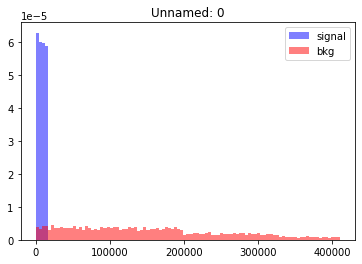

LeadJet_area


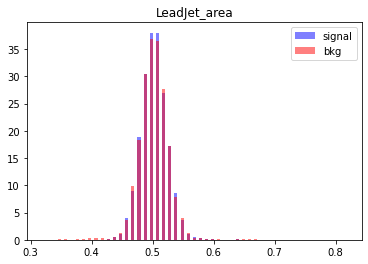

LeadJet_chHEF


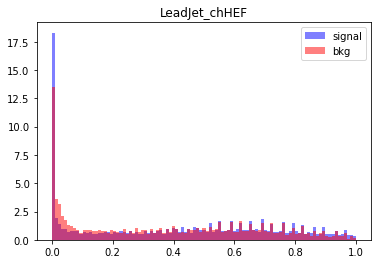

LeadJet_eta


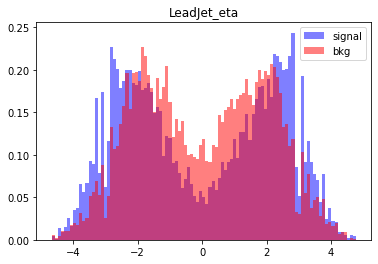

LeadJet_mass


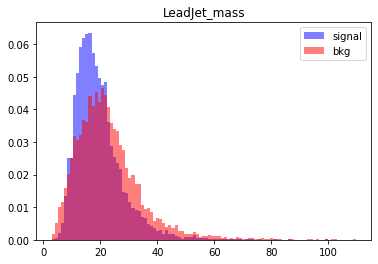

LeadJet_muEF


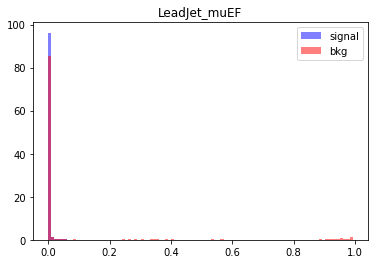

LeadJet_neEmEF


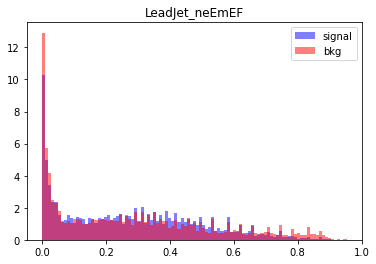

LeadJet_neHEF


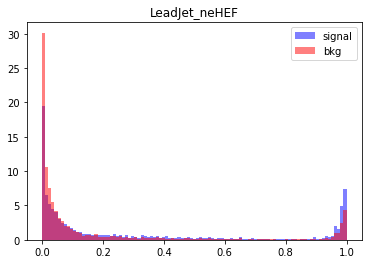

LeadJet_phi


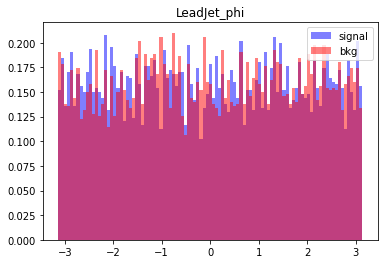

LeadJet_pt


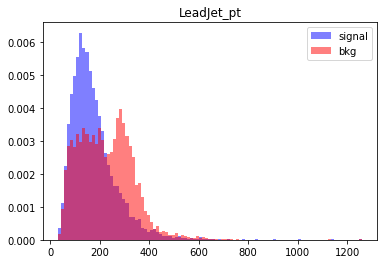

LeadJet_puIdDisc


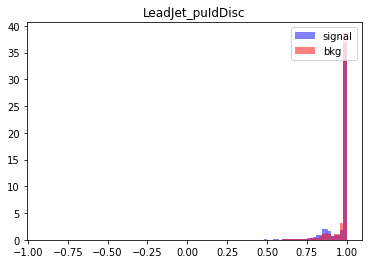

LeadJet_qgl


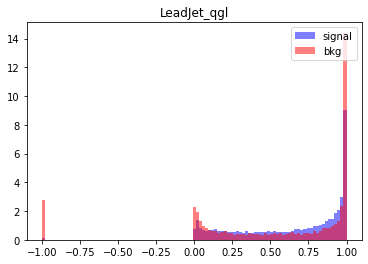

LeadJet_rawFactor


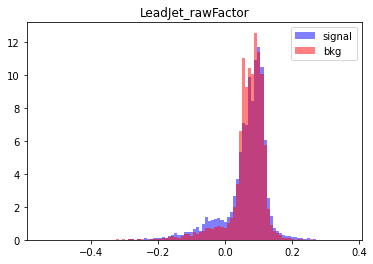

LeadJet_jetId


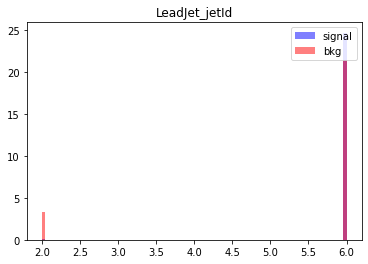

LeadJet_nConstituents


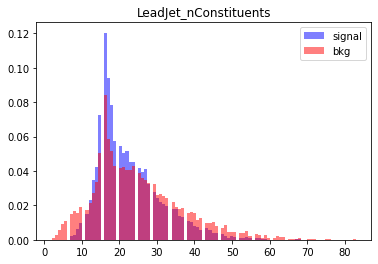

LeadJet_nElectrons


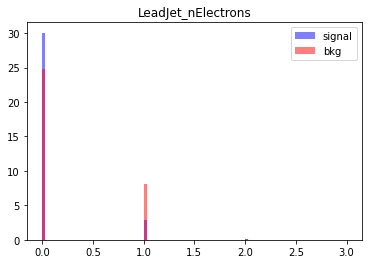

LeadJet_nMuons


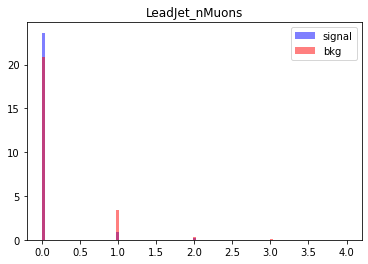

LeadJet_puId


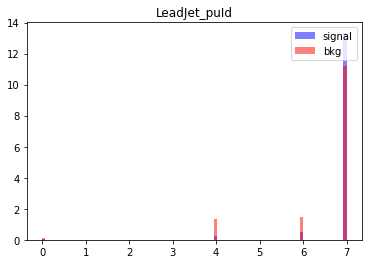

SubLeadJet_area


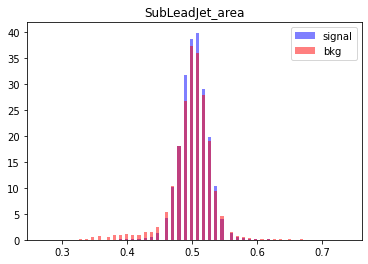

SubLeadJet_chHEF


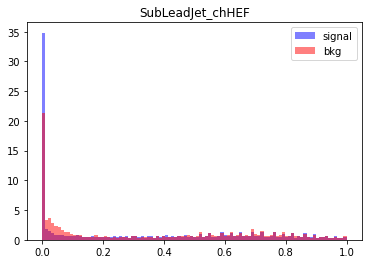

SubLeadJet_eta


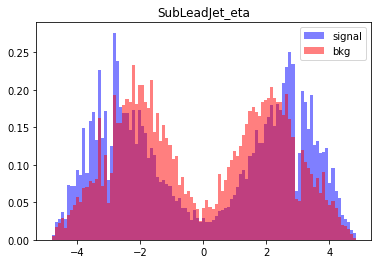

SubLeadJet_mass


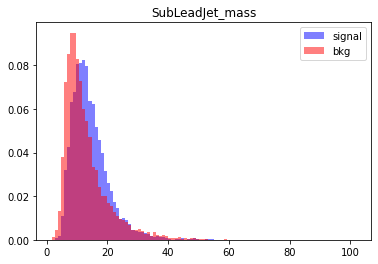

SubLeadJet_muEF


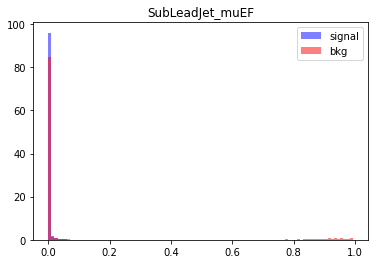

SubLeadJet_neEmEF


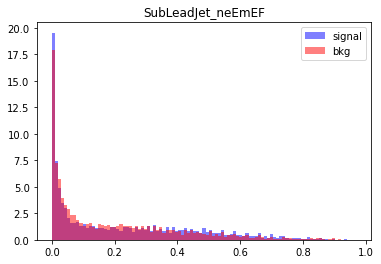

SubLeadJet_neHEF


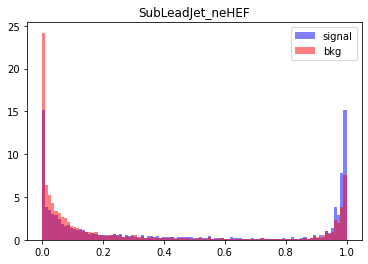

SubLeadJet_phi


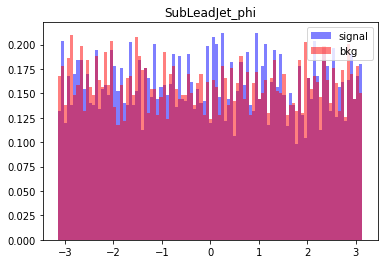

SubLeadJet_pt


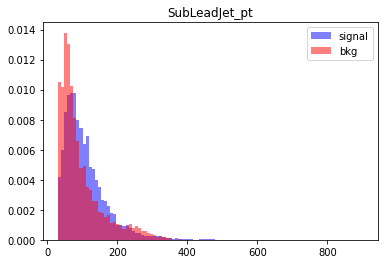

SubLeadJet_puIdDisc


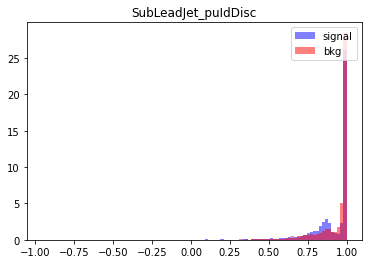

SubLeadJet_qgl


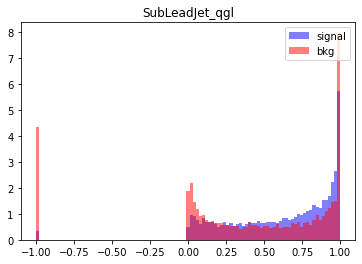

SubLeadJet_rawFactor


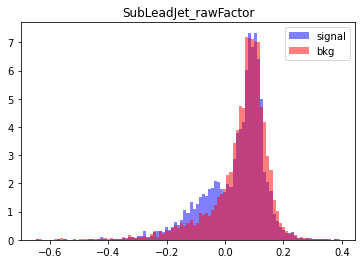

SubLeadJet_jetId


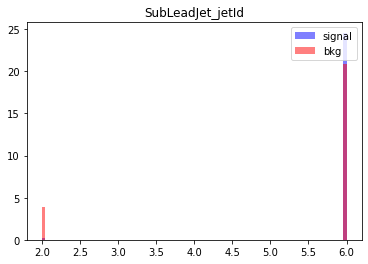

SubLeadJet_nConstituents


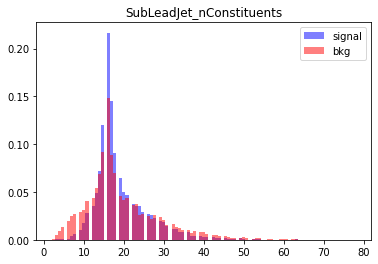

SubLeadJet_nElectrons


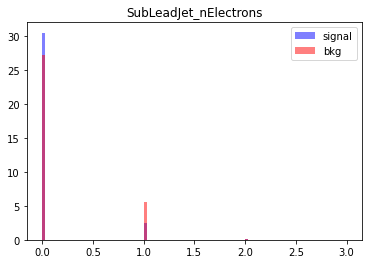

SubLeadJet_nMuons


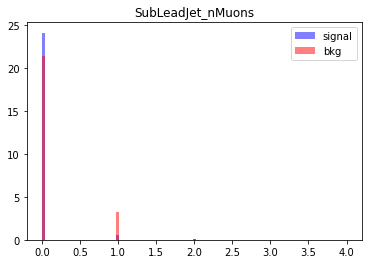

SubLeadJet_puId


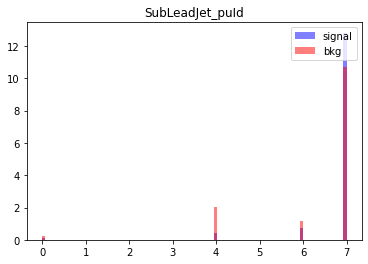

mjj


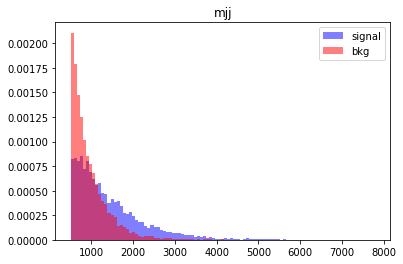

DeltaEtajj


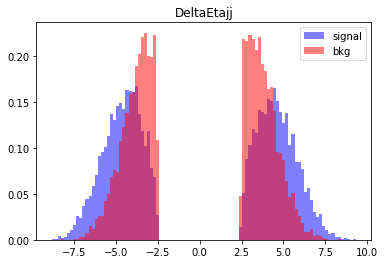

In [8]:
plot_variables(sig,bkg)

# Check correlation

<AxesSubplot:>

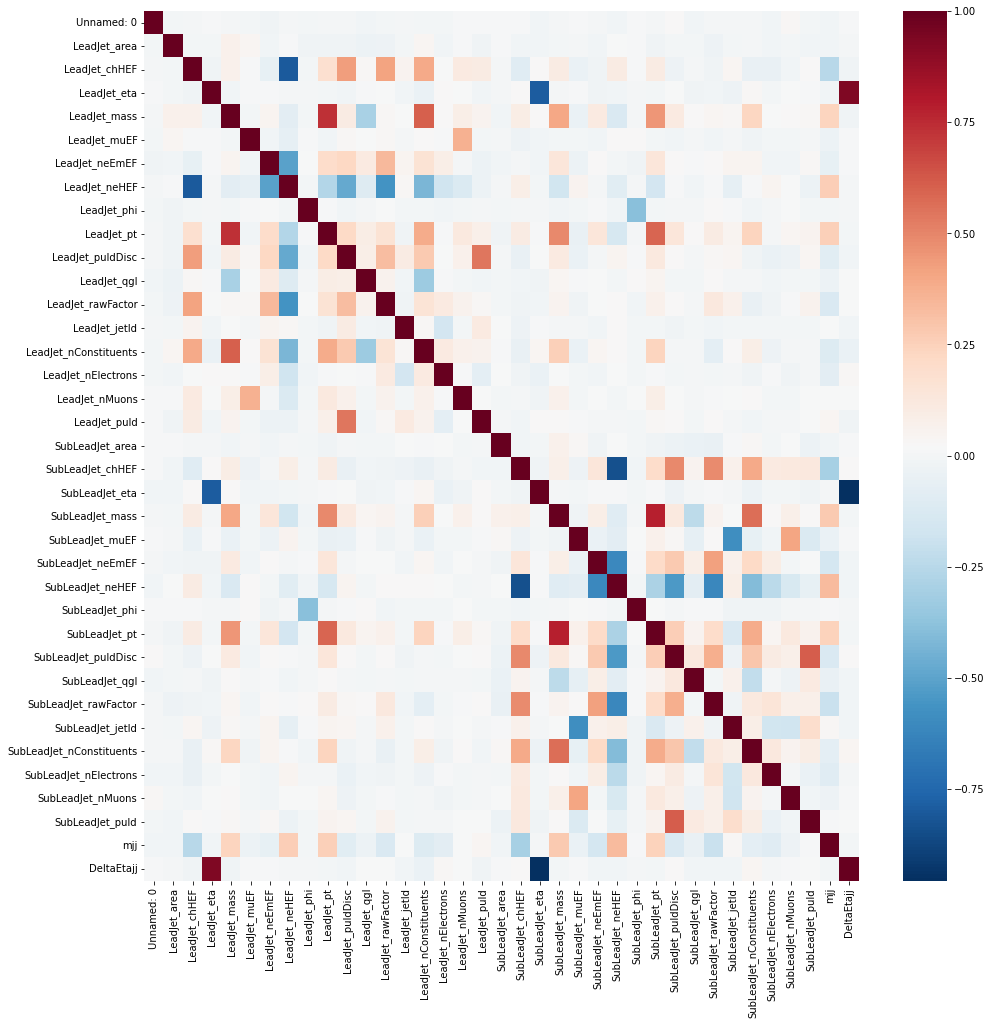

In [9]:
corr = sig.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(16,16))
sn.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,  cmap = "RdBu_r")

<AxesSubplot:>

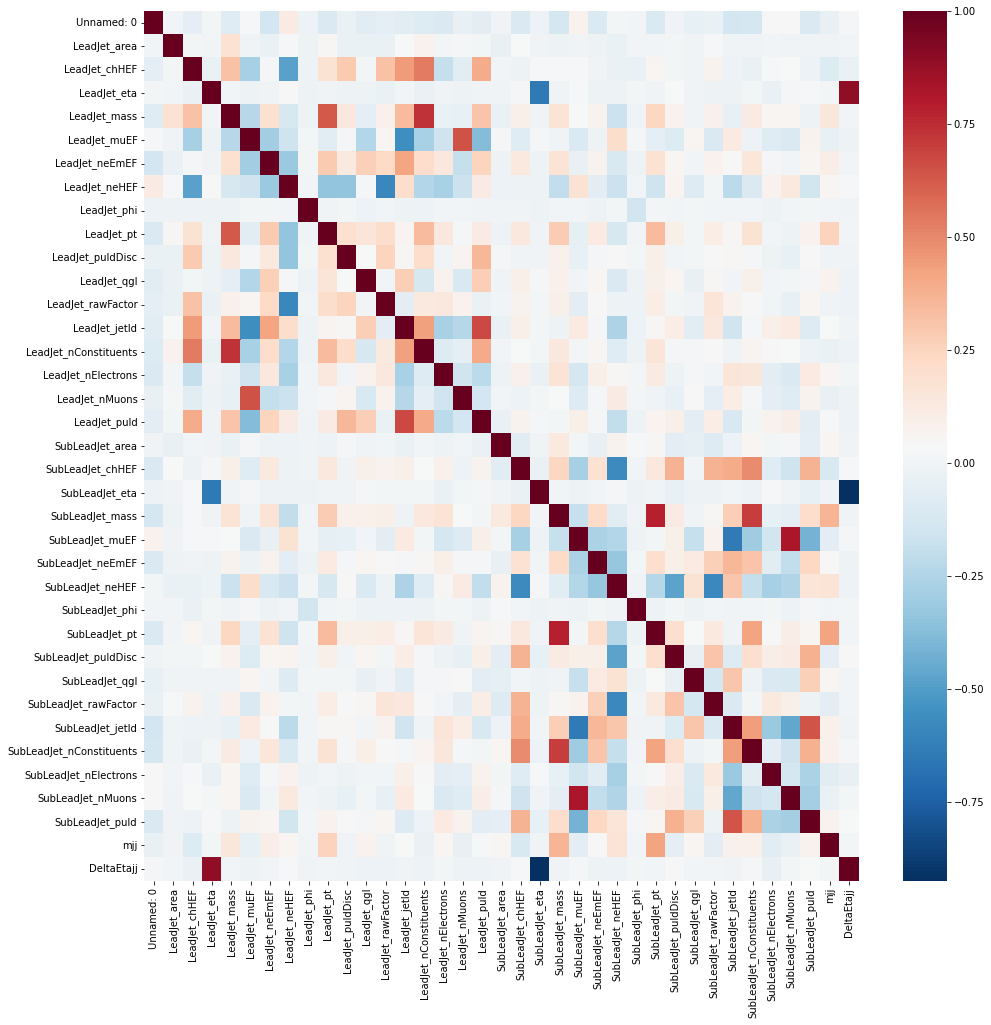

In [10]:
corr = bkg.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(16,16))
sn.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,  cmap = "RdBu_r")

# Keep selected variables

In [11]:
to_drop = ["Unnamed: 0", "LeadJet_rawFactor", "SubLeadJet_rawFactor", "LeadJet_qgl", "SubLeadJet_qgl"]

sig = sig.drop(columns = to_drop)
bkg = bkg.drop(columns = to_drop)

#to_keep = ["LeadJet_area", "SubLeadJet_area"]

#sig = sig[to_keep]
#bkg = bkg[to_keep]

In [12]:
sig

,LeadJet_area,LeadJet_chHEF,LeadJet_eta,LeadJet_mass,LeadJet_muEF,LeadJet_neEmEF,LeadJet_neHEF,LeadJet_phi,LeadJet_pt,LeadJet_puIdDisc,...,SubLeadJet_phi,SubLeadJet_pt,SubLeadJet_puIdDisc,SubLeadJet_jetId,SubLeadJet_nConstituents,SubLeadJet_nElectrons,SubLeadJet_nMuons,SubLeadJet_puId,mjj,DeltaEtajj
0,0.538574,0.000000,-3.287598,25.828125,0.000000,0.000595,0.992188,0.138367,181.1250,0.888184,...,2.989746,100.18750,0.995605,6.0,14.0,0.0,0.0,7.0,1735.999390,-5.100342
1,0.508789,0.695312,2.285156,13.906250,0.000000,0.281250,0.019531,-2.447266,104.7500,0.787598,...,0.441589,121.18750,0.879395,6.0,16.0,0.0,0.0,7.0,1943.728882,5.688965
2,0.478760,0.044434,-2.834961,19.890625,0.000000,0.585938,0.371094,-3.118652,229.1250,0.979980,...,-0.665405,152.37500,0.997559,6.0,21.0,0.0,0.0,7.0,1186.977051,-3.656250
3,0.518555,0.000000,-3.099609,25.812500,0.000000,0.014160,0.984375,2.387207,207.6250,0.886230,...,-0.601074,119.43750,0.997070,6.0,15.0,1.0,0.0,7.0,1983.565186,-5.053711
4,0.518555,0.000000,3.468750,30.265625,0.000000,0.000000,1.000000,-0.746338,195.7500,0.863281,...,3.013184,120.31250,0.990723,6.0,21.0,0.0,0.0,7.0,1147.751709,3.990845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7868,0.518555,0.000000,-3.539062,7.976562,0.000000,0.022949,0.976562,-1.267334,42.4375,0.651855,...,1.338623,33.53125,0.832520,6.0,17.0,0.0,0.0,7.0,1335.958374,-7.132812
7869,0.498779,0.992188,1.993652,9.468750,0.000000,0.000000,0.000000,-1.592773,60.6250,0.996582,...,-0.147369,50.84375,0.524902,6.0,15.0,0.0,0.0,4.0,1044.734375,5.869629
7870,0.508789,0.781250,1.774170,33.031250,0.004578,0.201172,0.013062,-1.302002,303.0000,0.998535,...,2.334473,79.75000,0.759277,6.0,16.0,0.0,0.0,7.0,2861.805664,5.820068
7871,0.498779,0.562500,2.094238,17.343750,0.000000,0.410156,0.000000,-0.015482,198.5000,0.993164,...,-1.702393,146.75000,0.959961,6.0,19.0,0.0,0.0,7.0,1977.928955,4.897949


# Define train and test set

In [13]:
X_sig = sig.to_numpy()
X_bkg= bkg.to_numpy()
y_sig = np.ones(X_sig.shape[0])
y_bkg = - np.ones(X_bkg.shape[0])
X = np.concatenate([X_sig,X_bkg])
y = np.concatenate([y_sig,y_bkg])
#X_shuffled, y_shuffled = shuffle(X, y)
#split_value = 940
#split_value = int(X.shape[0]*5./6.)
'''
split_value = int(X.shape[0]*1./2.)
X_train, X_test = X_shuffled[:split_value], X_shuffled[split_value:]
y_train, y_test = y_shuffled[:split_value], y_shuffled[split_value:]
'''

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.5, random_state=42, shuffle = True)

print(X_train.shape[0])
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print(X_test.shape[0])
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

7872
{-1.0: 3920, 1.0: 3952}
7873
{-1.0: 3952, 1.0: 3921}


# Define and train a classifier

In [14]:
n_trees = 150

model = AdaBoostClassifier(n_estimators=n_trees, learning_rate=0.1).fit(X_train, y_train)

#model = GradientBoostingClassifier(n_estimators=n_trees, learning_rate=0.1, max_depth=2,verbose=1).fit(X_train, y_train,)

# Check output score

sig KstestResult(statistic=0.024865782917065486, pvalue=0.1711354951759324)
bkg KstestResult(statistic=0.022433487565066513, pvalue=0.26939638771342755)


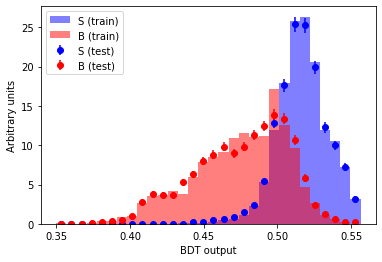

In [15]:
compare_train_test(model, X_train, y_train, X_test, y_test)

# Check ROC curve

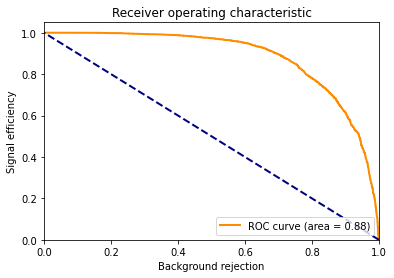

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(1. - fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([1, 0], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background rejection')
plt.ylabel('Signal efficiency')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Check feature importance

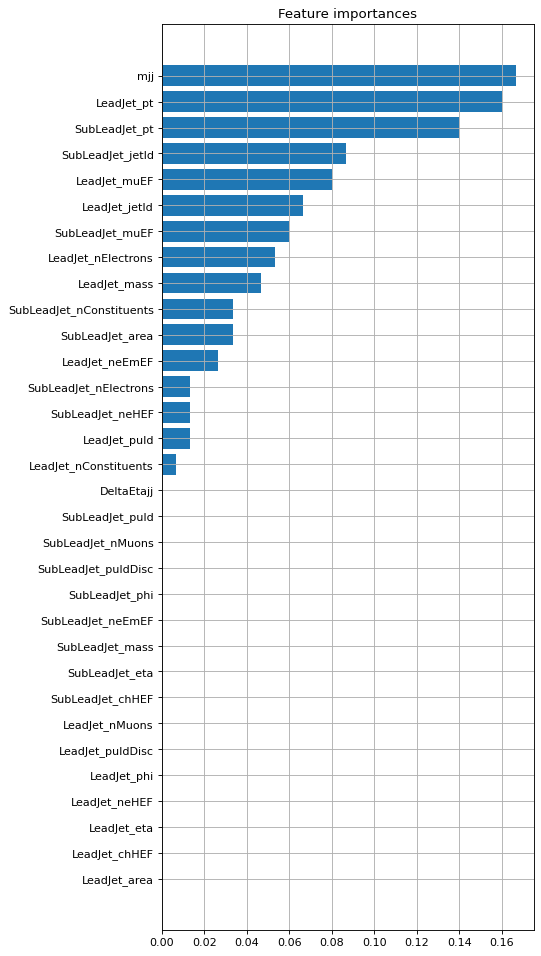

In [19]:
importance = model.feature_importances_
columns = sig.columns
zipped = zip (columns, importance)
z = list(sorted(zipped, key = lambda t: t[1],reverse=False))
x = [z_[0].split('[')[0] for z_ in z]
y = [z_[1] for z_ in z ]
plt.figure(num=None, figsize=(6, 15), dpi=80, facecolor='w', edgecolor='k')
plt.barh(x, y)
plt.grid()
plt.title("Feature importances")
plt.show()

# Check learning curves

150


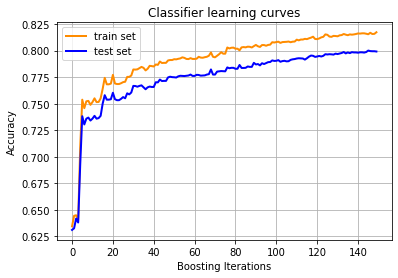

In [20]:
####in case of sklearn
train_accuracy = np.zeros((n_trees,), dtype=np.float64)
test_accuracy = np.zeros((n_trees,), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_accuracy[i] = accuracy_score(y_test,y_pred,)
for i, y_pred in enumerate(model.staged_predict(X_train)):
    train_accuracy[i] = accuracy_score(y_train,y_pred,)
print(len(test_accuracy))
plt.plot(range(0,len(train_accuracy)),train_accuracy, color='darkorange',lw=lw, label='train set')
plt.plot(range(0,len(test_accuracy)),test_accuracy, color='blue',lw=lw, label='test set')
plt.title('Classifier learning curves')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

# Save the model

In [21]:
import pickle

filehandler = open("model.p","wb")
pickle.dump(model, filehandler)
filehandler.close()